Lucas Auada Braga
Vitor Kenzo Koga Onoue

4/5 - Vitor Onoue - Starting data preparation

4/6 - Vitor Onoue - Finished data preparation + EDA

5/31 - Lucas Braga - Second notebook containing model training steps

5/31 - Vitor Onoue - Merging both notebooks + adding comments

In this notebook, we are preparing and cleaning an e-commerce dataset from Olist, in order to train a model to predict if an order's delivery will be delayed.

After selecting the fields that will be used, we are also making a very simple EDA.

In [39]:
import pandas as pd

Taking a look at each csv file

In [40]:
orders = pd.read_csv('csvs/olist_orders_dataset.csv')
orders.sample()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
55097,cdf7511b632d2a9b53d70b1e24a45e70,fc2f06b2af43f8be78736cd991ca8486,delivered,2018-07-04 16:35:27,2018-07-05 16:15:56,2018-07-05 13:30:00,2018-07-07 17:37:36,2018-07-30 00:00:00


In [41]:
customers = pd.read_csv('csvs/olist_customers_dataset.csv')
customers.sample()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
24834,bbcf8ece3eb8126cd7e507284ede76c7,8c628e66ad97ce2163d23d1156e19a0e,22220,rio de janeiro,RJ


In [42]:
order_items = pd.read_csv('csvs/olist_order_items_dataset.csv')
order_items.sample()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
89251,cab899336401fd910bf645dc446d42de,1,33b22110fa818ff5f0c387a79f19b612,6b243f80ed07b10f0e8aa0f21a205f3c,2017-11-30 02:53:00,54.9,15.82


Treating orders

In [43]:
# cleaning rows where the order_delivered_customer_date is null (treating as not delivered)
orders = orders.dropna(subset=['order_delivered_customer_date'])

# converting date columns to datetime format
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

# creating a new column for the estimated delivery in days
orders['estimated_delivery_days'] = (orders['order_estimated_delivery_date'] - orders['order_purchase_timestamp']).dt.days

# creating a new column for month of purchase
orders['purchase_month'] = orders['order_purchase_timestamp'].dt.month

# creating a delay column by checking if the date the customer received the order is greater than what was expected
orders['delay'] = (orders['order_delivered_customer_date'] > orders['order_estimated_delivery_date']).astype(bool)

Treating customers

In [44]:
# for the customers csv, only using the customer_state field - removing rows with null values for this field
customers = customers.dropna(subset=['customer_state'])

Treating order_items

In [45]:
# for the order_items csv, only using the freight_value field - removing rows with null values for this field
order_items = order_items.dropna(subset=['freight_value'])

Each row in order_items contains a product and an order it is associated to

Which means that we may have multiple rows with the same order_id, as an order can have multiple products

The goal is to predict a possible delay in the delivery of an **order**, so we are transforming multiple rows with the same order_id into a single row

We are considering each product having its own freight tax, and if an order contains, for example, 3 products, the total freight value will be the sum of all products' freight values

In [46]:
order_items_agg = order_items.groupby('order_id').agg({
    'freight_value': 'sum',
    'price': 'sum',
    'order_item_id': 'count'
}).rename(columns={
    'price': 'order_price',
    'order_item_id': 'item_count'
}).reset_index()

Merging all the csvs together into a single csv, with only the fields we are going to use

In [47]:
dataset = orders.merge(order_items_agg, on='order_id', how='left')
dataset = dataset.merge(customers, on='customer_id', how='left')

columns = ['order_purchase_timestamp',
                      'order_estimated_delivery_date', 'order_delivered_customer_date',
                      'customer_state', 'order_price', 'freight_value', 'estimated_delivery_days', 'purchase_month', 'delay']
dataset[columns].to_csv('csvs/clean_dataset.csv', index=False)

dataset[columns].sample()

,order_purchase_timestamp,order_estimated_delivery_date,order_delivered_customer_date,customer_state,order_price,freight_value,estimated_delivery_days,purchase_month,delay
34537,2018-04-21 14:30:01,2018-05-15,2018-04-27 22:23:41,SP,195.0,25.02,23,4,False


Starting Exploratory Data Analysis

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_csv('csvs/clean_dataset.csv')

In [49]:
# First five rows
dataset.head()

,order_purchase_timestamp,order_estimated_delivery_date,order_delivered_customer_date,customer_state,order_price,freight_value,estimated_delivery_days,purchase_month,delay
0,2017-10-02 10:56:33,2017-10-18,2017-10-10 21:25:13,SP,29.99,8.72,15,10,False
1,2018-07-24 20:41:37,2018-08-13,2018-08-07 15:27:45,BA,118.70,22.76,19,7,False
2,2018-08-08 08:38:49,2018-09-04,2018-08-17 18:06:29,GO,159.90,19.22,26,8,False
3,2017-11-18 19:28:06,2017-12-15,2017-12-02 00:28:42,RN,45.00,27.20,26,11,False
4,2018-02-13 21:18:39,2018-02-26,2018-02-16 18:17:02,SP,19.90,8.72,12,2,False


In [50]:
# General info
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96476 entries, 0 to 96475
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_purchase_timestamp       96476 non-null  object 
 1   order_estimated_delivery_date  96476 non-null  object 
 2   order_delivered_customer_date  96476 non-null  object 
 3   customer_state                 96476 non-null  object 
 4   order_price                    96476 non-null  float64
 5   freight_value                  96476 non-null  float64
 6   estimated_delivery_days        96476 non-null  int64  
 7   purchase_month                 96476 non-null  int64  
 8   delay                          96476 non-null  bool   
dtypes: bool(1), float64(2), int64(2), object(4)
memory usage: 6.0+ MB
None


In [51]:
# Checking null values - as they were removed previously, expected to be 0
print(dataset.isnull().sum())

order_purchase_timestamp         0
order_estimated_delivery_date    0
order_delivered_customer_date    0
customer_state                   0
order_price                      0
freight_value                    0
estimated_delivery_days          0
purchase_month                   0
delay                            0
dtype: int64


In [52]:
# Calculating delay
dataset['order_purchase_timestamp'] = pd.to_datetime(dataset['order_purchase_timestamp'])
dataset['order_estimated_delivery_date'] = pd.to_datetime(dataset['order_estimated_delivery_date'])
dataset['order_delivered_customer_date'] = pd.to_datetime(dataset['order_delivered_customer_date'])

dataset['delay_in_days'] = (dataset['order_delivered_customer_date'] - dataset['order_estimated_delivery_date']).dt.days
dataset['delay_in_days'].sample(5)

36444    -8
55699    -7
11024   -18
36791    -4
57461    -9
Name: delay_in_days, dtype: int64

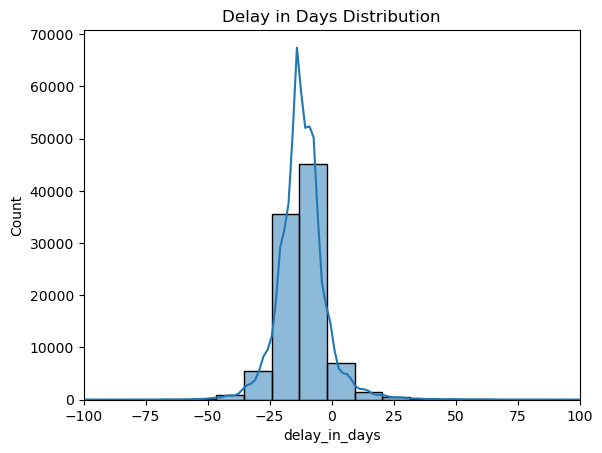

In [53]:
# Delay histogram
sns.histplot(dataset['delay_in_days'].dropna(), bins=30, kde=True)
plt.title('Delay in Days Distribution')
plt.xlim(-100, 100)
plt.show()

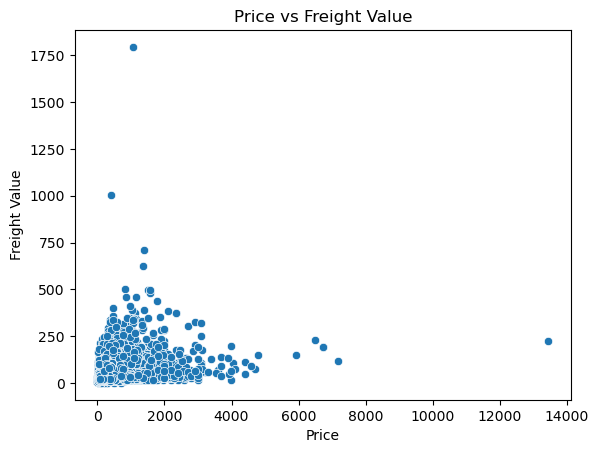

In [54]:
# Price vs Freight value scatter
sns.scatterplot(data=dataset, x='order_price', y='freight_value')
plt.title('Price vs Freight Value')
plt.xlabel('Price')
plt.ylabel('Freight Value')
plt.show()

Model training steps:

+ select the feature columns and the target column
+ split training and testing data
+ choose the algorithm and train the model
+ print and analyze the results

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

orders = pd.read_csv('csvs/clean_dataset.csv')


In [31]:
# one-hot encoding customer_state
orders = pd.get_dummies(orders, columns=['customer_state'], drop_first=True)

# selecting features and target
x = orders[['order_price', 'freight_value', 'estimated_delivery_days', 'purchase_month'] + [col for col in orders.columns if col.startswith('customer_state_')]]
y = orders['delay']

# splitting the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# normalizing the features, as logistic regression will be sensitive to the high/low values of order_price and freight_value
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
# training with logistic regression - the low amount of falses requires class balance
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(x_train_scaled, y_train)
y_pred_lr = lr.predict(x_test_scaled)

In [33]:
print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_lr))

Logistic Regression
              precision    recall  f1-score   support

       False       0.95      0.64      0.77     26577
        True       0.13      0.63      0.22      2366

    accuracy                           0.64     28943
   macro avg       0.54      0.64      0.49     28943
weighted avg       0.88      0.64      0.72     28943

Confusion matrix:
[[17039  9538]
 [  878  1488]]


In [ ]:
# training with random forest - the low amount of falses requires class balance
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

In [35]:
print("Random Forest")
print(classification_report(y_test, y_pred_rf))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest
              precision    recall  f1-score   support

       False       0.92      0.98      0.95     26577
        True       0.32      0.10      0.15      2366

    accuracy                           0.91     28943
   macro avg       0.62      0.54      0.55     28943
weighted avg       0.88      0.91      0.89     28943

Confusion matrix:
[[26068   509]
 [ 2127   239]]
